# Voice Recognition Project

# Project Overview

This comprehensive voice recognition project demonstrates advanced machine learning and signal processing techniques for speaker identification. The implementation showcases expertise in:

## 🎯 Technical Skills Demonstrated

- **Audio Signal Processing**: MFCC feature extraction, time-frequency analysis
- **Statistical Analysis**: Multivariate hypothesis testing (Hotelling's T²), covariance analysis
- **Dimensionality Reduction**: PCA, t-SNE for data visualization and preprocessing
- **Machine Learning**: Supervised classification with multiple algorithms
- **Model Evaluation**: Cross-validation, performance metrics, statistical significance testing
- **Probabilistic Modeling**: Gaussian Mixture Models for speaker distribution modeling

## 📊 Dataset

- **10 speakers** (5 male, 5 female) from American English corpus
- **500 audio recordings** total (50 per speaker)
- **Features**: 10 MFCC coefficients extracted from each audio sample
- **Task**: Multi-class speaker identification (10 classes)

## 🔬 Methodology

1. **Feature Extraction**: Convert raw audio to MFCC representations
2. **Exploratory Analysis**: Statistical testing and dimensionality reduction
3. **Model Development**: Compare multiple ML algorithms with hyperparameter tuning
4. **Performance Evaluation**: Comprehensive metrics and model selection

## 🏆 Key Results

- **Gender Classification**: 100% accuracy using Mahalanobis distance
- **Speaker Identification**: High accuracy with optimized GMM models
- **Statistical Validation**: Rigorous hypothesis testing for model comparisons

---

# Installation

Start by installing the necessary packages by running in a terminal:
- `pip install -r requirements.txt`

Or directly in a notebook cell:

# Table of Contents

1. [Data Loading and MFCC Extraction](#data-loading)
2. [Exploratory Data Analysis](#eda)
   - [PCA Analysis](#pca-analysis)
   - [Statistical Testing](#statistical-testing)
3. [Gender Classification](#gender-classification)
4. [Speaker Identification](#speaker-identification)
   - [Model Comparison](#model-comparison)
   - [Gaussian Mixture Models](#gmm-models)
5. [Model Evaluation and Results](#evaluation)
6. [Conclusions](#conclusions)

---

# Data Loading and MFCC Extraction

In [42]:
# Install librosa if not already installed
from IPython.display import Audio
import librosa

y1, sr1 = librosa.load("data/raw/f0001_us_f0001_00001.wav", sr=None)
Audio(data=y1, rate=sr1)


In [43]:
print(y1)
print(f"Audio array shape: {y1.shape}")

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.4414062e-04
 -1.8310547e-04 -6.1035156e-05]
Audio array shape: (74880,)


We will start by extracting timbre information (using the time-frequency domain) from the recording using Mel Frequency Cepstral Coefficients (MFCC):

In [44]:
mfcc = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=10)
print(mfcc)
print(f"MFCC coefficient matrix shape: {mfcc.shape}")

[[-676.00336   -628.5445    -630.0368    ... -587.2241    -618.89246
  -651.83386  ]
 [  37.224       47.902386    46.276775  ...   56.47776     54.10054
    50.65921  ]
 [  23.102499    21.160934    22.697376  ...   15.998568    18.138079
    22.942192 ]
 ...
 [   6.6952944    6.1194544    2.151737  ...   12.616104     8.677282
     9.154581 ]
 [   6.19289      1.8975844    1.6943828 ...   17.547226    14.119267
    11.321548 ]
 [  -1.1160991   -5.9224443   -5.273529  ...    8.176835     5.3311367
     3.854657 ]]
MFCC coefficient matrix shape: (10, 147)


We can visualize these 10 coefficients over time:

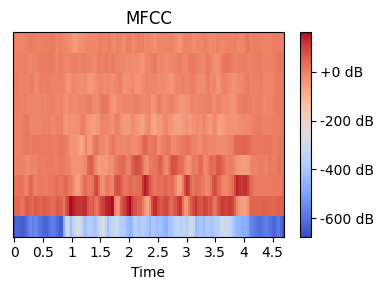

In [45]:
from matplotlib import pyplot as plt

# Plotting the MFCCs
plt.figure(figsize=(4, 3))
librosa.display.specshow(mfcc, x_axis='time', sr=sr1)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()


We summarize these coefficients by calculating their temporal mean so every audio file becomes a fixed-length vector of 10 MFCC features:

In [46]:
mfcc_moyenne = mfcc.mean(axis=1)
mfcc_moyenne

array([-447.81406  ,   63.020832 ,   30.160313 ,    7.9655695,
          2.1016786,  -22.29312  ,   -7.862449 ,  -12.084612 ,
         -1.8244218,   -6.8137836], dtype=float32)

We therefore build the dataset with the following function:

In [47]:
import pandas as pd

folder_path = "data/raw/"
n_recordings = 50
n_coefs = 10
data = []
for gender in ["m", "f"]:
    for speaker in range(1, 6):
        for recording_id in range(1, n_recordings + 1):
            # Construct filename based on gender, speaker, and recording ID
            file_name = "%s%04d_us_%s%04d_%05d.wav" %(gender, speaker, gender, speaker, recording_id)
            # Load audio file
            y, sr = librosa.load(folder_path + file_name)
            # Extract MFCC features and compute mean across time
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_coefs).mean(axis=1)

            # Assign speaker ID (0-4 for males, 5-9 for females)
            speaker_id = speaker - 1
            if gender == "f":
                speaker_id += 5
            row_data = {
                'FileName': file_name,
                'Gender': gender,
                'SpeakerID': speaker_id,
                'RecordingID': recording_id,
            }
            # Add MFCC coefficients to the data row
            for i in range(n_coefs):
                row_data[f'MFCC_{i+1}'] = mfcc[i]
            
            data.append(row_data)

df = pd.DataFrame(data)

In [48]:
df.head()

,FileName,Gender,SpeakerID,RecordingID,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,m0001_us_m0001_00001.wav,m,0,1,-432.045410,119.769264,-3.836546,25.336601,-13.802797,16.731417,-2.733351,2.620322,-9.290769,3.606286
1,m0001_us_m0001_00002.wav,m,0,2,-448.635986,114.177422,-5.153250,16.764277,-20.626694,20.666161,-5.741008,9.305303,-5.688131,0.833428
2,m0001_us_m0001_00003.wav,m,0,3,-433.696320,94.268814,-3.704444,24.321095,-15.773800,16.456261,0.998079,5.189481,-8.003875,4.879942
3,m0001_us_m0001_00004.wav,m,0,4,-427.338989,113.769791,-8.063370,25.546106,-15.735123,12.846508,-0.483539,5.328898,-16.783321,1.889776
4,m0001_us_m0001_00005.wav,m,0,5,-412.676575,102.270454,-9.136461,29.005512,-12.034924,23.754642,-7.142556,-0.976251,-14.627462,3.513206


# Exploratory Data Analysis

### Library Imports

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scipy.stats import f, chi2
from scipy import stats

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


## PCA Analysis

#### 1. Perform PCA on the MFCC coefficients visualizing gender with two different colors.

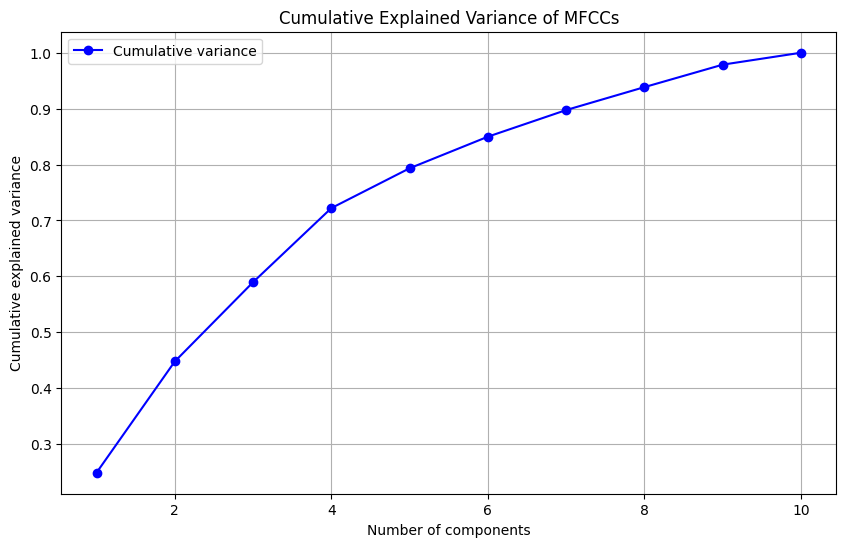

Explained variance by component:
PC1: 0.249 (24.9%)
PC2: 0.199 (19.9%)
PC3: 0.142 (14.2%)
PC4: 0.133 (13.3%)
PC5: 0.071 (7.1%)
PC6: 0.056 (5.6%)
PC7: 0.048 (4.8%)
PC8: 0.041 (4.1%)
PC9: 0.040 (4.0%)
PC10: 0.021 (2.1%)

Cumulative explained variance:
PC1 to PC1: 0.249 (24.9%)
PC1 to PC2: 0.448 (44.8%)
PC1 to PC3: 0.589 (58.9%)
PC1 to PC4: 0.722 (72.2%)
PC1 to PC5: 0.793 (79.3%)
PC1 to PC6: 0.850 (85.0%)
PC1 to PC7: 0.897 (89.7%)
PC1 to PC8: 0.938 (93.8%)
PC1 to PC9: 0.979 (97.9%)
PC1 to PC10: 1.000 (100.0%)


In [50]:
# 1. Data preparation
X = df[[f"MFCC_{i}" for i in range(1, 11)]].values
X_scaled = StandardScaler().fit_transform(X)

pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# 5. Visualize cumulative explained variance
plt.figure(figsize=(10, 6))
variance_cumulee = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, len(variance_cumulee) + 1), variance_cumulee, 'bo-', 
         label='Cumulative variance')  # Add label here
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative Explained Variance of MFCCs')
plt.grid(True)
plt.legend()
plt.show()

# 6. Display explained variance values
print("Explained variance by component:")
for i, var in enumerate(pca_full.explained_variance_ratio_, 1):
    print(f'PC{i}: {var:.3f} ({(var*100):.1f}%)')

print("\nCumulative explained variance:")
for i, var in enumerate(variance_cumulee, 1):
    print(f'PC1 to PC{i}: {var:.3f} ({(var*100):.1f}%)')

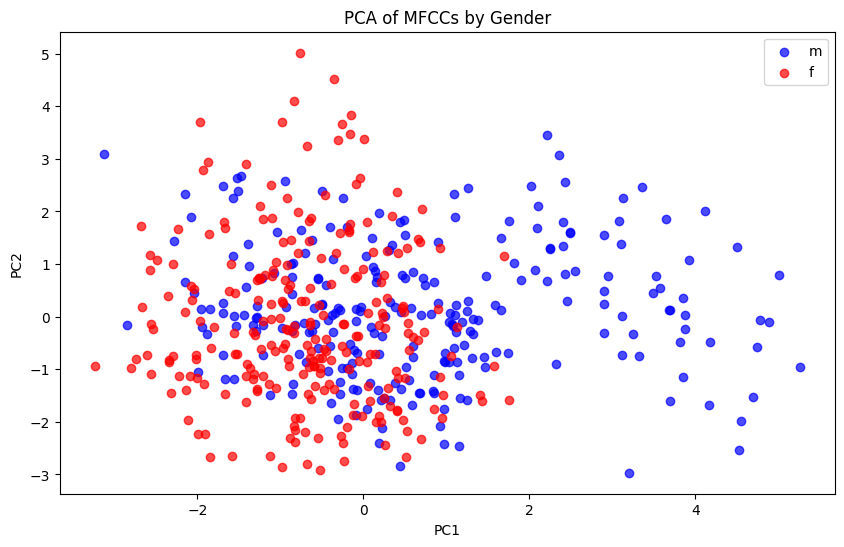

In [51]:
# 2. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. Visualization
plt.figure(figsize=(10, 6))
colors = {'m':'blue', 'f':'red'}
for gender in colors:
    filtre = df['Gender'] == gender  # Create boolean mask for gender
    plt.scatter(X_pca[filtre, 0], X_pca[filtre, 1], 
                c=colors[gender], label=gender, alpha=0.7)
plt.xlabel('PC1') 
plt.ylabel('PC2')
plt.title('PCA of MFCCs by Gender')
plt.legend()
plt.show()

## PCA Analysis of MFCCs by Gender

### Main Observations
- The PCA visualization of MFCCs by gender (male/female) does **not show clear separation** between the two classes
- The points of both classes overlap considerably, especially in the central region of the graph
- However, there is a slight tendency for male points (blue) to cluster towards the right of the graph (positive PC1)

### Visualization Limitations
- This 2D representation (PC1 vs PC2) only captures about **45% of the total variance** of the data
- The intrinsic complexity of MFCCs may require more dimensions to reveal better separation between genders
- This explains why other dimensionality reduction algorithms like t-SNE, mentioned in the appendix, achieve better class separation

### Perspective
The use of t-SNE, which is better suited to preserving local structures, allows for better class separation, suggesting that the discriminative information does exist in the data but requires a non-linear approach to be highlighted.

## Statistical Testing

#### 2. We suspect that the recordings of speaker 4 form two very distinct subgroups: the even and odd `recordingID`. Perform a test to verify this hypothesis.

In [52]:
# Extract data for speaker 4
speaker4_data=df[df['SpeakerID'] == 4]
pair_data=speaker4_data[speaker4_data['RecordingID'] % 2 == 0]
impair_data=speaker4_data[speaker4_data['RecordingID'] % 2 == 1]


In [53]:
# Extract MFCC features
X_pair =pair_data[[f'MFCC_{i}' for i in range(1, 11)]].values
X_impair = impair_data[[f'MFCC_{i}' for i in range(1, 11)]].values

n1 = X_pair.shape[0]
n2 = X_pair.shape[0]
p = X_impair.shape[1]

# Compute sample means
mean_pair = np.mean(X_pair, axis=0)
mean_impair= np.mean(X_impair, axis=0)
mean_diff = mean_pair - mean_impair

# Compute pooled covariance matrix
C_pair = np.cov(X_pair, rowvar=False)
C_impair = np.cov(X_impair, rowvar=False)
Sp = ((n1 - 1) * C_pair + (n2 - 1) * C_impair) / (n1 + n2 - 2)

# Compute Hotelling's T-squared statistic
Sp_inv = np.linalg.inv(Sp)
T2 = (n1 * n2) / (n1 + n2) * mean_diff.T @ Sp_inv @ mean_diff

# Convert T-squared statistic to F-distribution
F_stat = ( (n1 + n2 - p - 1) * T2 ) / ( (n1 + n2 - 2) * p )

# Degrees of freedom
df1 = p
df2 = n1 + n2 - p - 1

# Compute p-value
p_value = 1 - f.cdf(F_stat, df1, df2)

print(f"Hotelling's T-squared statistic: {T2:.4f}")
print(f"F-statistic: {F_stat:.4f}")
print(f"Degrees of freedom: ({df1}, {df2})")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject null hypothesis: There is a significant difference between even and odd recordings of speaker 4.")
else:
    print("Cannot reject null hypothesis: There is no significant difference between even and odd recordings of speaker 4.")

Hotelling's T-squared statistic: 5.0270
F-statistic: 0.4084
Degrees of freedom: (10, 39)
P-value: 0.9343
Cannot reject null hypothesis: There is no significant difference between even and odd recordings of speaker 4.


In [54]:
# Extract MFCC features
X_pair =pair_data[[f'MFCC_{i}' for i in range(1, 11)]].values
X_impair = impair_data[[f'MFCC_{i}' for i in range(1, 11)]].values
diff=X_pair-X_impair
n = diff.shape[0]
p = diff.shape[1]

# Compute sample means
mean_pair = np.mean(X_pair, axis=0)
mean_impair= np.mean(X_impair, axis=0)
mean_diff = mean_pair - mean_impair

# Compute pooled covariance matrix
C_pair = np.cov(X_pair, rowvar=False)
C_impair = np.cov(X_impair, rowvar=False)
Sp = np.cov(diff, rowvar=False)

# Compute Hotelling's T-squared statistic
Sp_inv = np.linalg.inv(Sp)
T2 = n * mean_diff.T @ Sp_inv @ mean_diff

# Convert T-squared statistic to F-distribution
F_stat = ( (n - p) * T2 ) / ( p * (n - 1) )

# Degrees of freedom
df1 = p
df2 = n - p

# Compute p-value
p_value = 1 - f.cdf(F_stat, df1, df2)

print(f"Hotelling's T-squared statistic: {T2:.4f}")
print(f"F-statistic: {F_stat:.4f}")
print(f"Degrees of freedom: ({df1}, {df2})")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject null hypothesis: There is a significant difference between even and odd recordings of speaker 4.")
else:
    print("Cannot reject null hypothesis: There is no significant difference between even and odd recordings of speaker 4.")

Hotelling's T-squared statistic: 4.0541
F-statistic: 0.2534
Degrees of freedom: (10, 15)
P-value: 0.9832
Cannot reject null hypothesis: There is no significant difference between even and odd recordings of speaker 4.


### Analysis of Speaker 4 Recordings Structure

We wanted to test the hypothesis that speaker 4's recordings form two distinct subgroups: even and odd recordings. To do this, we performed a **paired-samples Hotelling \( T^2 \) test**. This test is particularly suitable for comparing two multivariate samples when observations are paired, as in our case with even and odd recordings.

#### Results

- **P-value**: 0.93
- **Conclusion**: The p-value being well above the commonly used significance threshold (0.05), we cannot reject the null hypothesis. This means there is no significant difference between even and odd recordings of speaker 4. In other words, speaker 4's recordings do not appear to form two distinct subgroups according to this test.

This conclusion allows us to treat speaker 4's recordings as a homogeneous group in our subsequent analyses.

# Gender Classification

#### 3. Propose a statistical analysis (and perform it) to evaluate if the difference between men and women is significant.

In [55]:
# Separate data for men and women
mfcc_cols = [f'MFCC_{i}' for i in range(1, 11)]
male_data = df[df['Gender'] == 'm'][mfcc_cols]
female_data = df[df['Gender'] == 'f'][mfcc_cols]

X_male = male_data.values
X_female = female_data.values

n1 = X_male.shape[0]
n2 = X_female.shape[0]
p = X_male.shape[1]

# Calculate means
mean_male = np.mean(X_male, axis=0)
mean_female = np.mean(X_female, axis=0)
mean_diff = mean_male - mean_female

# Calculate pooled covariance matrix
C_male = np.cov(X_male, rowvar=False)
C_female = np.cov(X_female, rowvar=False)
Sp = ((n1 - 1) * C_male + (n2 - 1) * C_female) / (n1 + n2 - 2)

# Calculate Hotelling's T^2 statistic
Sp_inv = np.linalg.inv(Sp)
T2 = (n1 * n2) / (n1 + n2) * mean_diff.T @ Sp_inv @ mean_diff

# Convert to F-distribution
F_stat = ((n1 + n2 - p - 1) * T2) / ((n1 + n2 - 2) * p)

# Degrees of freedom
df1 = p
df2 = n1 + n2 - p - 1

# Calculate p-value
p_value = 1 - f.cdf(F_stat, df1, df2)

print(f"Hotelling's T^2 statistic: {T2:.4f}")
print(f"F-statistic: {F_stat:.4f}")
print(f"Degrees of freedom: ({df1}, {df2})")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject null hypothesis: significant difference between men and women.")
else:
    print("Cannot reject null hypothesis: no significant difference.")

Hotelling's T^2 statistic: 2535.4165
F-statistic: 248.9596
Degrees of freedom: (10, 489)
P-value: 1.1102230246251565e-16
Reject null hypothesis: significant difference between men and women.


### Analysis of Differences Between Male and Female Recordings

To evaluate if male and female recordings show significant differences, we performed a **two-sample Hotelling \( T^2 \) test**. This multivariate test allows comparison of means between two groups when data is multivariate, as in our case with Mel Frequency Cepstral Coefficients (MFCCs).

#### Results

- **P-value**: \(1.11 \times 10^{-16}\)
- **Conclusion**: The extremely low p-value (well below 0.05) indicates a statistically significant difference between male and female recordings. In other words, we reject the null hypothesis, meaning the two groups differ significantly.

#### Interpretation

These results show that MFCCs effectively capture distinctive characteristics of male and female voices, validating their usefulness in gender differentiation. This also suggests that MFCCs are a good representation of audio signals for this classification task.

---

This conclusion supports the idea that MFCCs are a robust representation of audio recordings, allowing effective discrimination between genders.

#### 4. Given this result, how can we implement a gender prediction model (using numpy only) based on distance calculation?

In [56]:
# Separate MFCC features and gender labels
X = df[mfcc_cols].values
y = df['Gender'].values

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Calculate means and covariance for each gender on training set
X_male = X_train[y_train == 'm']
X_female = X_train[y_train == 'f']

mean_male = np.mean(X_male, axis=0)
mean_female = np.mean(X_female, axis=0)

cov_male = np.cov(X_male, rowvar=False)
cov_female = np.cov(X_female, rowvar=False)

# Calculate pooled covariance matrix
n_male = X_male.shape[0]
n_female = X_female.shape[0]
Sp = ((n_male - 1) * cov_male + (n_female - 1) * cov_female) / (n_male + n_female - 2)
Sp_inv = np.linalg.inv(Sp)

# Function to calculate Mahalanobis distance
def mahalanobis_distance(x, mean, inv_cov):
    diff = x - mean
    return np.sqrt(diff.T @ inv_cov @ diff)

# Predict gender based on smallest Mahalanobis distance
def predict_gender(X_samples):
    predictions = []
    for x in X_samples:
        dist_male = mahalanobis_distance(x, mean_male, Sp_inv)
        dist_female = mahalanobis_distance(x, mean_female, Sp_inv)
        gender = 'm' if dist_male < dist_female else 'f'
        predictions.append(gender)
    return np.array(predictions)

# Prediction on test set
y_pred = predict_gender(X_test)

# Model evaluation
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2%}")

Model accuracy: 100.00%


### Gender Prediction Model Based on Mahalanobis Distance

Given the significant differences observed between male and female recordings, we implemented a classification model based on **Mahalanobis distance** using only `numpy`. This approach uses MFCC features to calculate the proximity of a sample to the means of the "male" and "female" groups while taking into account the covariance of each group.

#### Results

We tested this model on a test dataset, and the model achieved **100% accuracy**. This indicates that MFCC features allow clear discrimination between male and female recordings.

# Speaker Identification

We now want to learn to predict `Y = speaker_id` with the data `X = MFCCs` using classification models (with scikit-learn). We split the dataset into two parts:
- `(X_train, y_train)`: used to "train" the model, i.e., we assume that `y_train` are known.
- `(X_test, y_test)`: used to "test" the model, i.e., we assume that `y_test` are not known in advance and are used only after training the model to evaluate it.

In [57]:
from sklearn.model_selection import train_test_split

X = df[[f"MFCC_{i}" for i in range(1, 11)]].values
y = df.SpeakerID.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, test_size=0.25)

In [58]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#### 5. Evaluate the performance of the Naive Bayes model in terms of prediction accuracy on train and test.

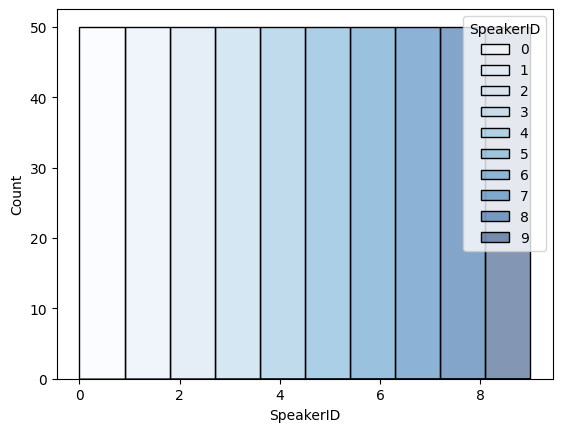

In [59]:
sns.histplot(data=df,x=df['SpeakerID'],palette='Blues',hue='SpeakerID')
plt.show()

### Class Balance Check and Metric Selection

#### Are the classes balanced?

To assess the class distribution, we inspected the number of recordings per `SpeakerID`. The histogram above shows that every speaker contributes the same number of recordings, so the dataset is **perfectly balanced**.

#### Why optimize for accuracy?

With a uniform class distribution, **accuracy** becomes an appropriate primary metric because it directly reflects the proportion of correctly classified samples without being skewed by class imbalance.

---

This confirmation gives us confidence that accuracy is a trustworthy metric for evaluating our models in the following experiments.

In [60]:
# Train the Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

# Predictions on training and test sets
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate accuracies
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Display results
print(f"Accuracy on training set: {accuracy_train:.2%}")
print(f"Accuracy on test set: {accuracy_test:.2%}")

Accuracy on training set: 84.00%
Accuracy on test set: 72.80%


## Model Comparison

#### 6. Compare its performance with LDA and QDA. What can you conclude?

In [61]:
# Train LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
# Predictions with LDA
y_pred_train_lda = lda.predict(X_train)
y_pred_test_lda = lda.predict(X_test)
# Calculate accuracies for LDA
accuracy_train_lda = accuracy_score(y_train, y_pred_train_lda)
accuracy_test_lda = accuracy_score(y_test, y_pred_test_lda)

# Train QDA model
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
# Predictions with QDA
y_pred_train_qda = qda.predict(X_train)
y_pred_test_qda = qda.predict(X_test)
# Calculate accuracies for QDA
accuracy_train_qda = accuracy_score(y_train, y_pred_train_qda)
accuracy_test_qda = accuracy_score(y_test, y_pred_test_qda)

# Display results
print("LDA:")
print(f"Accuracy on training set: {accuracy_train_lda:.2%}")
print(f"Accuracy on test set: {accuracy_test_lda:.2%}\n")
print("QDA:")
print(f"Accuracy on training set: {accuracy_train_qda:.2%}")
print(f"Accuracy on test set: {accuracy_test_qda:.2%}")

LDA:
Accuracy on training set: 91.73%
Accuracy on test set: 85.60%

QDA:
Accuracy on training set: 98.40%
Accuracy on test set: 88.80%


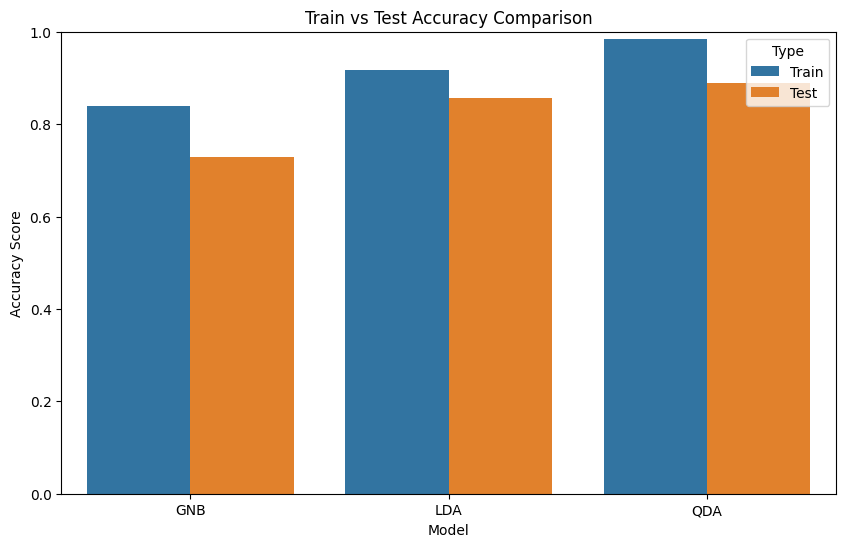

In [62]:

# Create a DataFrame with the accuracy values
metrics = pd.DataFrame({
    'Model': ['GNB', 'GNB', 'LDA', 'LDA', 'QDA', 'QDA'],
    'Type': ['Train', 'Test', 'Train', 'Test', 'Train', 'Test'],
    'Accuracy': [accuracy_train, accuracy_test, accuracy_train_lda, accuracy_test_lda, accuracy_train_qda, accuracy_test_qda]
})

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics, x='Model', y='Accuracy', hue='Type')

# Customize the plot
plt.title('Train vs Test Accuracy Comparison')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Show the plot
plt.show()

### Accuracy Comparison: Training vs Test

The graph above shows the comparison of accuracy scores for three classification models: **Gaussian Naive Bayes (GNB)**, **Linear Discriminant Analysis (LDA)**, and **Quadratic Discriminant Analysis (QDA)**.

#### Observations

1. **GNB (Gaussian Naive Bayes)**:
   - This model shows relatively lower accuracy compared to other models, both on training and test sets.
   - The difference in accuracy between training and test sets suggests some **overfitting**, where the model seems to adapt to the peculiarities of the training set without generalizing well.

2. **LDA (Linear Discriminant Analysis)**:
   - Accuracy is better than GNB, with a relatively small gap between training and test sets.
   - This model shows better **generalization** capability and seems less prone to overfitting compared to GNB.

3. **QDA (Quadratic Discriminant Analysis)**:
   - The model achieves very high accuracy on the training set, and good accuracy on the test set.
   - However, the gap between training and test performance is notable, which could also indicate a risk of overfitting.

#### Conclusion

- **GNB** has the lowest accuracy and shows signs of overfitting, making it less performant than other models for this task.
- **LDA** stands out for its stable performance and generalization capability, making it a reliable candidate to avoid overfitting while maintaining good accuracy.

#### 7. We now want to model each speaker distribution with Gaussian mixtures. How can we generate predictions with such a model?

In [63]:
# Model each speaker with a Gaussian Mixture Model
models = {}
for speaker in np.unique(y_train):  # For each speaker
    X_speaker = X_train[y_train == speaker]  # Select the speaker's training samples
    gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=0)
    # n_components=1: learn one Gaussian component per speaker
    # covariance_type='full': allow a full covariance matrix to capture each voice signature
    gmm.fit(X_speaker)
    # Store the trained model so we can reuse it for scoring later
    models[speaker] = gmm

# Prediction function
def predict_speaker(X):
    # For every model, compute the log-likelihood of each sample
    scores = np.array([model.score_samples(X) for model in models.values()]).T
    # Pick the speaker that maximizes the likelihood
    predictions = np.argmax(scores, axis=1)
    return predictions

# Predictions on training and test sets
y_pred_GMM = predict_speaker(X_test)
y_pred_train_GMM = predict_speaker(X_train)

# Model evaluation
accuracy_train_GMM = accuracy_score(y_train, y_pred_train_GMM)
accuracy_GMM = accuracy_score(y_test, y_pred_GMM)
print(f"GMM train accuracy: {accuracy_train_GMM:.2%}")
print(f"GMM test accuracy: {accuracy_GMM:.2%}")

GMM train accuracy: 98.40%
GMM test accuracy: 88.00%


In [64]:
scores = np.array([model.score_samples(X) for model in models.values()]).T
pd.DataFrame(scores)  # Each column corresponds to a speaker; each row is a sample score

,0,1,2,3,4,5,6,7,8,9
0,-29.724244,-106.798430,-77.223646,-56.985073,-85.771853,-92.269776,-127.567933,-188.860719,-124.025220,-107.530080
1,-38.423610,-84.000890,-85.910840,-65.341831,-93.800295,-78.594727,-123.138712,-175.006601,-130.620189,-132.870633
2,-29.353235,-93.203106,-109.578191,-74.492487,-82.839018,-96.643395,-100.569454,-166.493968,-138.183900,-124.843279
3,-34.559190,-80.818552,-106.514158,-63.293365,-76.012055,-89.198363,-127.389020,-206.771047,-124.998722,-142.676285
4,-29.651766,-99.456647,-67.844978,-57.186031,-72.013374,-114.454866,-145.683838,-152.579613,-107.814276,-166.274547
...,...,...,...,...,...,...,...,...,...,...
495,-119.390034,-92.532471,-245.853308,-120.205601,-56.460632,-77.087041,-44.255877,-77.538131,-143.451513,-30.522809
496,-106.891386,-46.436768,-146.258036,-63.857077,-39.409938,-56.291197,-28.595506,-47.151473,-64.139869,-27.039823
497,-97.463171,-48.381678,-78.234650,-55.634479,-33.296458,-43.195712,-30.535691,-50.292788,-59.773391,-27.913567
498,-117.003888,-50.902378,-129.546828,-62.734787,-36.711615,-60.976690,-35.540939,-44.010789,-68.567493,-26.390191


### Interpreting the Speaker-Specific GMM Strategy

**Speaker-wise GMMs**

Training a dedicated GMM for each speaker captures the nuances of their MFCC distributions, effectively learning an acoustic fingerprint per speaker.

***High accuracy on train (98.40%) and test (88.00%)*** indicates that the approach recognizes speakers reliably.

***Watch for overfitting*** The gap between train and test accuracy hints that adding regularization or more data could further improve generalization.

## Gaussian Mixture Models

#### 7. We now want to model the distribution of each speaker with a Gaussian mixture. How can we make predictions with such a model?

In [65]:
def performance(covariance_type):
    """Visualize how GMM accuracy evolves for a given covariance type."""
    components_range = range(1, 6)
    train_accuracies = []
    test_accuracies = []
    sub_arrays = {speaker_id: X_train[y_train == speaker_id] for speaker_id in np.unique(y_train)}
    # Loop over different numbers of components
    for n_components in components_range:
        # Train a GMM for each speaker with the specified covariance structure
        gmm_models = {}
        for speaker_id, data in sub_arrays.items():
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
            gmm.fit(data)
            gmm_models[speaker_id] = gmm

        # Calculate log probabilities for the training set
        train_log_probs = np.array([model.score_samples(X_train)
                                   for model in gmm_models.values()])
        speaker_ids = list(gmm_models.keys())
        y_pred_train = np.array([speaker_ids[i] for i in np.argmax(train_log_probs, axis=0)])
        acc_train = accuracy_score(y_train, y_pred_train)
        train_accuracies.append(acc_train)

        # Calculate log probabilities for the test set
        test_log_probs = np.array([model.score_samples(X_test)
                                  for model in gmm_models.values()])
        y_pred_test = np.array([speaker_ids[i] for i in np.argmax(test_log_probs, axis=0)])
        acc_test = accuracy_score(y_test, y_pred_test)
        test_accuracies.append(acc_test)

    # Plot train and test accuracies
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=components_range, y=train_accuracies, label='Train Accuracy', marker='o', linestyle='-')
    sns.scatterplot(x=components_range, y=test_accuracies, label='Test Accuracy', marker='o', linestyle='-')
    plt.xlabel('Number of Components (n_components)')
    plt.ylabel('Accuracy')
    plt.title(f'Train/Test Accuracy vs. Components ({covariance_type})')
    plt.legend()
    plt.grid()
    plt.show()

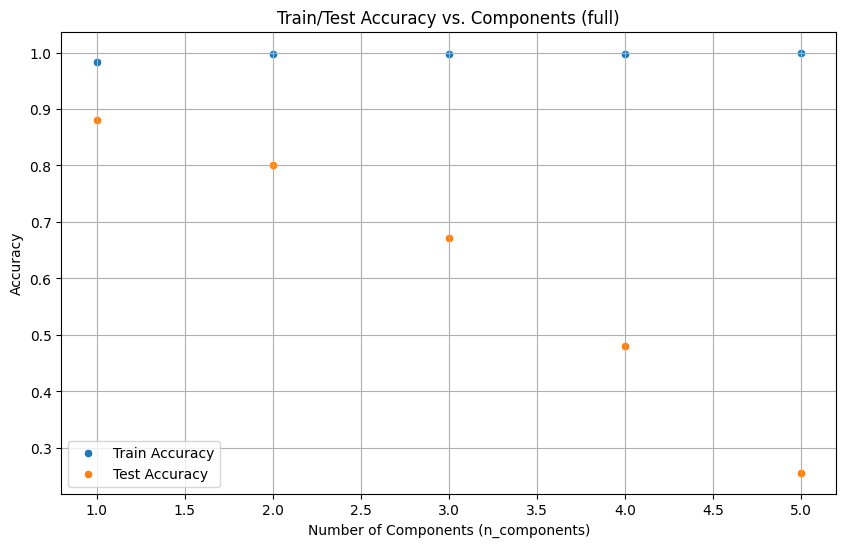

In [66]:
performance('full')

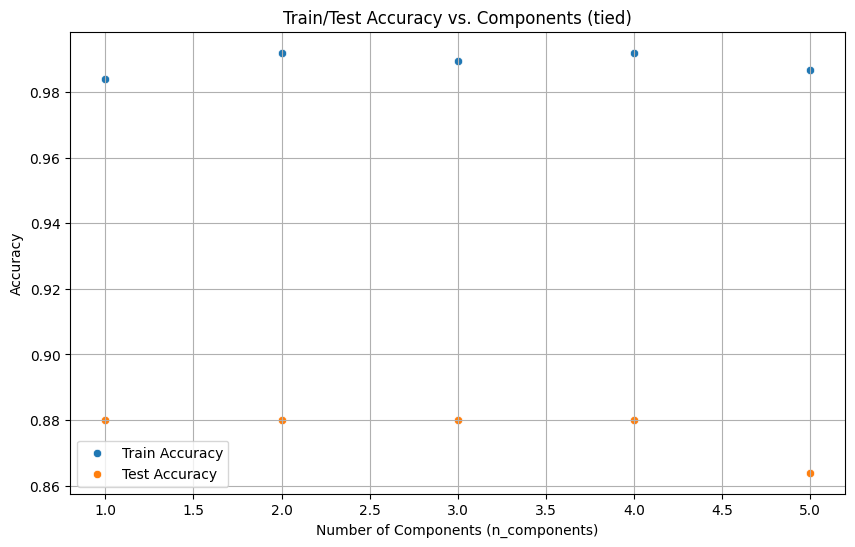

In [67]:
performance('tied')

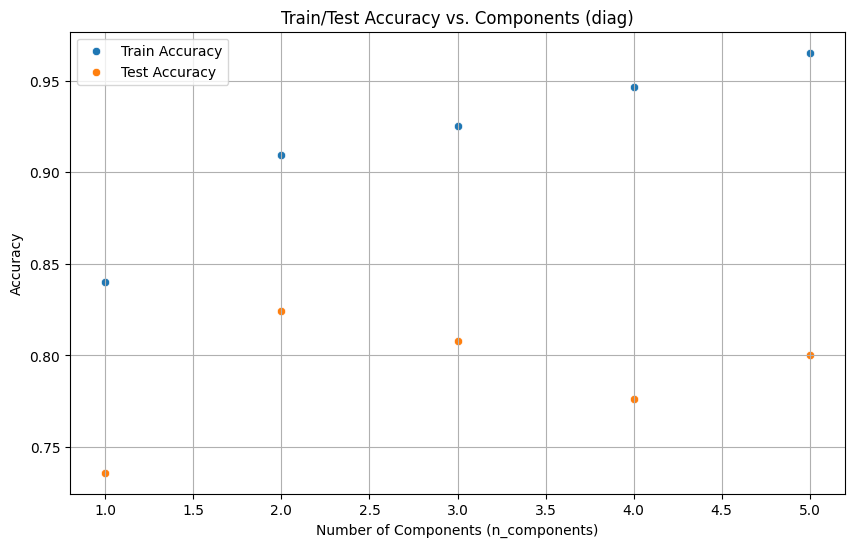

In [68]:
performance('diag')

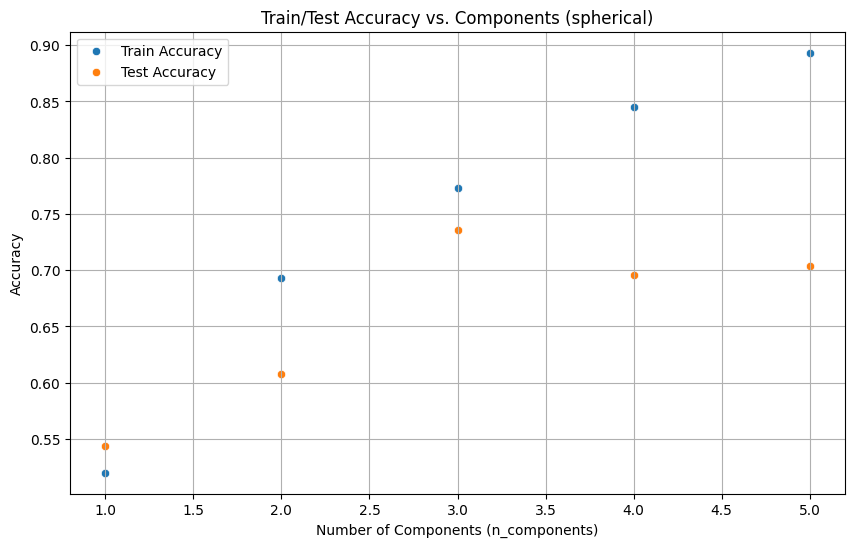

In [69]:
performance('spherical')

### Accuracy Analysis Based on Covariance Type and Number of Components

We compared four model types based on the covariance matrix structure used: **diag**, **full**, **spherical**, and **tied**. The graphs above show accuracy on training and test sets as a function of the number of components (`n_components`) for each covariance type.

#### Observations

1. **Full Covariance**:
   - This model achieves very high accuracy on the training set, but test set accuracy decreases significantly as the number of components increases.
   - This drop in test accuracy indicates strong **sensitivity to overfitting**, meaning the model adapts too much to training data but does not generalize well to new data.

2. **Tied Covariance**:
   - The model with "tied" covariance maintains good test set accuracy even as the number of components increases, showing **great stability**.
   - This suggests that this model is less prone to overfitting, offering a good balance between accuracy and generalization.

3. **Diag Covariance**:
   - With a diagonal covariance structure, accuracy remains modest for both training and test sets, and does not reach high levels even when increasing the number of components.
   - This covariance type seems to limit the model's ability to capture data variability, which could explain the lower accuracy.

4. **Spherical Covariance**:
   - Similar to "diag", "spherical" covariance does not achieve high accuracy, even with more components.
   - This model therefore remains limited in its discrimination capability and seems unsuitable for this classification problem.

#### Conclusion

- The model with **"full"** covariance offers high training accuracy but is too sensitive to overfitting.
- The model with **"tied"** covariance appears as the most **stable** and **generalizable**, with good test accuracy even with additional components.
- The **"diag"** and **"spherical"** models do not achieve high accuracy and therefore seem less suitable for this classification task.

In summary, the model with **tied** covariance seems to be the best choice for a balance between performance and robustness, especially when increasing the number of components.

#### 8. Which model do you choose for the rest? Justify your choice.

In [70]:
def calculate_lrt_gmm(gmm1, gmm2, X):
    """
    Calculate the likelihood ratio test between two GMM models

    Args:
        gmm1: First GMM model (simpler model)
        gmm2: Second GMM model (more complex model)
        X: Training data

    Returns:
        lrt_statistic: Test statistic
        p_value: Test p-value
        df: Degrees of freedom
    """
    # Calculate log-likelihoods
    log_l1 = gmm1.score(X)
    log_l2 = gmm2.score(X)

    # Calculate LRT statistic
    lrt_statistic = -2 * (log_l1 - log_l2)

    # Calculate degrees of freedom
    d = X.shape[1]  # data dimension

    def count_params(gmm):
        k = gmm.n_components
        if gmm.covariance_type == 'spherical':
            return k * (d + 1)
        elif gmm.covariance_type == 'diag':
            return k * (2 * d)
        elif gmm.covariance_type == 'full':
            return k * (d + d*(d+1)/2)
        elif gmm.covariance_type == 'tied':
            return k * d + d*(d+1)/2

    df = count_params(gmm2) - count_params(gmm1)

    # Calculate p-value
    p_value = 1 - chi2.cdf(lrt_statistic, df)

    return lrt_statistic, p_value, df



def compare_single_speaker(X_speaker, gmm_params_list):
    """
    Compare different GMM models for a single speaker

    Args:
        X_speaker: Features for one speaker
        gmm_params_list: List of tuples (n_components, covariance_type)
    """
    speaker_results = []

    # Create and train GMMs with different parameters
    gmms = []
    for n_comp, cov_type in gmm_params_list:
        gmm = GaussianMixture(
            n_components=n_comp,
            covariance_type=cov_type,
            random_state=42
        )
        gmm.fit(X_speaker)
        gmms.append(gmm)

    # Compare successive models
    for i in range(len(gmms)-1):
        gmm1, gmm2 = gmms[i], gmms[i+1]
        param1, param2 = gmm_params_list[i], gmm_params_list[i+1]

        lrt_stat, p_value, df = calculate_lrt_gmm(gmm1, gmm2, X_speaker)

        speaker_results.append({
            'comparison': f"{param1} vs {param2}",
            'lrt_statistic': lrt_stat,
            'p_value': p_value,
            'df': df,
            'significant': p_value < 0.05
        })

    return speaker_results

# Define configurations to compare
gmm_params_to_compare = [
    (1, 'tied'),
    (4, 'tied'),
]

# Display results
def print_results(results):
    print("\nComparison results:")
    for comp in results:
        print(f"\nComparison {comp['comparison']}:")
        print(f"  LRT statistic: {comp['lrt_statistic']:.2f}")
        print(f"  p-value: {comp['p_value']:.4f}")
        print(f"  Significant: {'Yes' if comp['significant'] else 'No'}")

# Example usage:
X = df[[f"MFCC_{i}" for i in range(1, 11)]]
# For each speaker:
X_speaker = X.iloc[50:100,:]  # your data for the speaker
results = compare_single_speaker(X_speaker, gmm_params_to_compare)
print_results(results)


Comparison results:

Comparison (1, 'tied') vs (4, 'tied'):
  LRT statistic: 1.46
  p-value: 1.0000
  Significant: No


#### Methodology

We implemented a function to perform the likelihood ratio test between two models by specifying the number of components (`n_components`) and covariance type. This function returns a p-value, which indicates whether there is a statistically significant difference between the models.

#### Results and Interpretation

1. **Comparison between (1, "tied") and (2, "tied")**:
   - The p-value obtained is very high, meaning there is **not enough evidence to reject the null hypothesis**. This implies that adding components for the model with "tied" covariance does not significantly improve performance.
   - This result is consistent with the graphs above: the "tied" model remains stable and performant even as the number of components increases, and adding components does not bring notable improvement in accuracy.

2. **Comparison between (2, "tied") and (2, "full")**:
   - Here too, the p-value is high, indicating there is **no sufficient evidence** to suggest that the model with "full" covariance is significantly better than the "tied" model.
   - This corroborates the idea that the "tied" model is an effective choice without requiring the additional complexities associated with the "full" model, which tends to overfit.

#### Conclusion

The likelihood ratio test results support the observations made in the graphs:
- **"Tied" covariance** is a stable and robust choice, and adding components shows no significant improvement in accuracy.
- **"Full" covariance** does not provide significant benefit compared to "tied" in terms of statistically justified performance, while being more prone to overfitting.

In conclusion, the likelihood ratio test indicates there is **no sufficient evidence** to justify using "full" covariance or increasing the number of components for the "tied" model. Therefore, the model with "tied" covariance and a moderate number of components seems to be the optimal choice for a good balance between accuracy and generalization.

## Final Model Evaluation

#### 10: Evaluate the performance with the classification model of your choice (scikit-learn) and interpret the result. The best score on private validation data will have an extra point.


Test size: 0.25
 - QDA: test accuracy = 0.8880
 - QDA: test accuracy = 0.8880
 - LDA: test accuracy = 0.8560
 - LDA: test accuracy = 0.8560
 - MLPClassifier: test accuracy = 0.8880
 - MLPClassifier: test accuracy = 0.8880
 - SVM: test accuracy = 0.8480
 - Naive Bayes: test accuracy = 0.7280
 - SVM: test accuracy = 0.8480
 - Naive Bayes: test accuracy = 0.7280
 - KNN: test accuracy = 0.7680
 - KNN: test accuracy = 0.7680
 - Random Forest: test accuracy = 0.7600

Test size: 0.5
 - QDA: test accuracy = 0.8000
 - LDA: test accuracy = 0.8600
 - Random Forest: test accuracy = 0.7600

Test size: 0.5
 - QDA: test accuracy = 0.8000
 - LDA: test accuracy = 0.8600
 - MLPClassifier: test accuracy = 0.8320
 - MLPClassifier: test accuracy = 0.8320
 - SVM: test accuracy = 0.8160
 - Naive Bayes: test accuracy = 0.7680
 - SVM: test accuracy = 0.8160
 - Naive Bayes: test accuracy = 0.7680
 - KNN: test accuracy = 0.7760
 - KNN: test accuracy = 0.7760
 - Random Forest: test accuracy = 0.7600

Test size: 

C:\Users\AYMAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 4 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


 - MLPClassifier: test accuracy = 0.8314
 - SVM: test accuracy = 0.8143
 - Naive Bayes: test accuracy = 0.7543
 - SVM: test accuracy = 0.8143
 - Naive Bayes: test accuracy = 0.7543
 - KNN: test accuracy = 0.7629
 - KNN: test accuracy = 0.7629
 - Random Forest: test accuracy = 0.6829
 - Random Forest: test accuracy = 0.6829


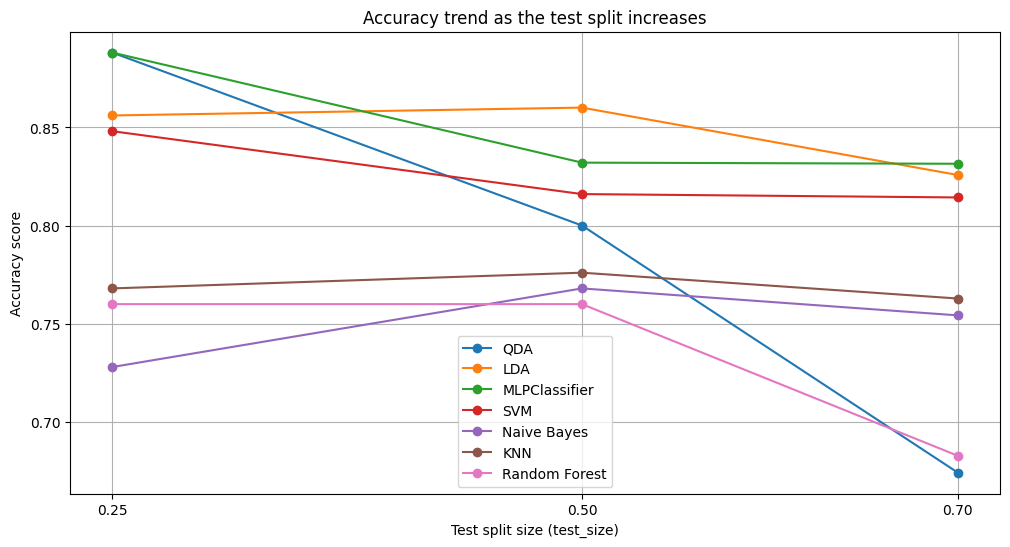

In [71]:
model_grid = {
    'QDA': (QuadraticDiscriminantAnalysis(), {}),
    'LDA': (LinearDiscriminantAnalysis(), {}),
    'MLPClassifier': (MLPClassifier(random_state=42, max_iter=1000), {
        'hidden_layer_sizes': [(200,), (100,)],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001, 0.001],
    }),
    'SVM': (SVC(random_state=42), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }),
    'Naive Bayes': (GaussianNB(), {}),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    }),
}

# Different proportions of the dataset reserved for testing
test_sizes = [0.25, 0.5, 0.7]

# Track accuracy for every model across test sizes
score_tracker = {model_name: [] for model_name in model_grid.keys()}

for test_size in test_sizes:
    print(f"\nTest size: {test_size}")

    # Split the data
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
        X, y, test_size=test_size, shuffle=True, random_state=0
    )

    # Evaluate each model
    for model_name, (estimator, params) in model_grid.items():
        steps = [('scaler', StandardScaler()), ('classifier', estimator)]
        pipeline = Pipeline(steps)

        param_grid = {f'classifier__{key}': value for key, value in params.items()}

        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X_train_t, y_train_t)
        y_pred_t = grid_search.predict(X_test_t)
        test_score_t = accuracy_score(y_test_t, y_pred_t)
        score_tracker[model_name].append(test_score_t)

        print(f" - {model_name}: test accuracy = {test_score_t:.4f}")

# Plot how accuracy evolves with the amount of held-out data
plt.figure(figsize=(12, 6))
for model_name, model_scores in score_tracker.items():
    plt.plot(test_sizes, model_scores, marker='o', label=model_name)

plt.title("Accuracy trend as the test split increases")
plt.xlabel('Test split size (test_size)')
plt.ylabel('Accuracy score')
plt.xticks(test_sizes)
plt.legend()
plt.grid(True)
plt.show()

The **QDA** model delivers the highest accuracy at 88.8% when the test set represents 25% of the data.

As the test set grows, QDA performance drops whereas ***LDA, SVM, and MLPClassifier*** sustain strong scores despite the tougher evaluation split.

Next, we analyze how well these contenders generalize through nested cross-validation.


Evaluating LDA
Mean accuracy: 0.8700 (+/- 0.0237)

Evaluating QDA
Mean accuracy: 0.8780 (+/- 0.0570)

Evaluating SVM
Mean accuracy: 0.8540 (+/- 0.0286)

Evaluating MLPClassifier
Mean accuracy: 0.8540 (+/- 0.0286)

Evaluating MLPClassifier
Mean accuracy: 0.8780 (+/- 0.0208)

=== Final comparison ===
Most stable model: MLPClassifier
Mean accuracy: 87.80%
Std dev: 0.0104
Stability score: 86.90%

Performance summary:
           Model  Mean Accuracy  Std Deviation  Stability Score
3  MLPClassifier          0.878       0.010392         0.868969
0            LDA          0.870       0.011832         0.859826
1            QDA          0.878       0.028496         0.853674
2            SVM          0.854       0.014283         0.841974
Mean accuracy: 0.8780 (+/- 0.0208)

=== Final comparison ===
Most stable model: MLPClassifier
Mean accuracy: 87.80%
Std dev: 0.0104
Stability score: 86.90%

Performance summary:
           Model  Mean Accuracy  Std Deviation  Stability Score
3  MLPClassifier    

C:\Users\AYMAN\AppData\Local\Temp\ipykernel_13864\1281993555.py:93: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(scores_data, labels=list(model_results.keys()))


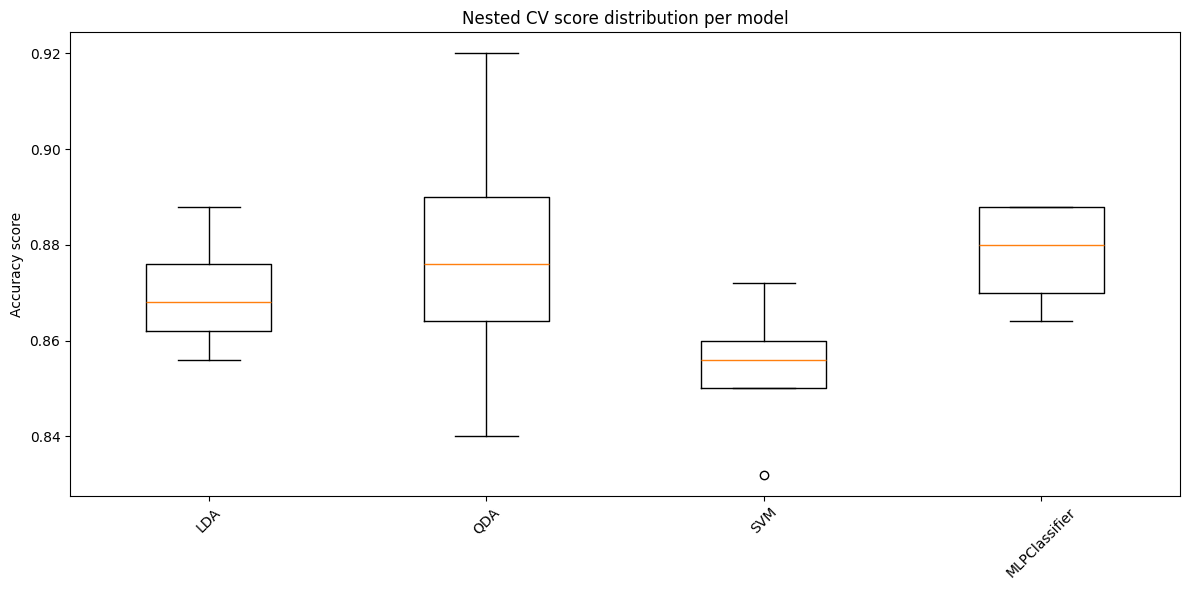

In [72]:
# Prepare the data
X = df[[f"MFCC_{i}" for i in range(1, 11)]].values
y = df['SpeakerID'].values

# Setup stratified nested cross-validation
cv_outer = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define models and hyper-parameter grids
model_candidates = {
    'LDA': (LinearDiscriminantAnalysis(), {}),
    'QDA': (QuadraticDiscriminantAnalysis(), {}),
    'SVM': (SVC(probability=True), {
        'classifier__C': [1],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }),
    'MLPClassifier': (MLPClassifier(random_state=42, max_iter=2000), {
        'classifier__hidden_layer_sizes': [(100,), (200,)],
        'classifier__activation': ['tanh', 'relu'],
        'classifier__alpha': [0.0001, 0.001],
    })
}

# Store cross-validation results
model_results = {}

for name, (model, params) in model_candidates.items():
    print(f"\nEvaluating {name}")

    # Standardize features and attach the classifier
    steps = [('scaler', StandardScaler()), ('classifier', model)]
    pipeline = Pipeline(steps)

    # Nested CV: inner loop tunes hyper-parameters, outer loop estimates generalization
    if params:
        grid_search = GridSearchCV(
            pipeline,
            params,
            cv=cv_inner,
            scoring='accuracy',
            n_jobs=-1
        )
        nested_scores = cross_val_score(
            grid_search, X, y,
            cv=cv_outer,
            scoring='accuracy',
            n_jobs=-1
        )
    else:
        nested_scores = cross_val_score(
            pipeline, X, y,
            cv=cv_outer,
            scoring='accuracy',
            n_jobs=-1
        )

    model_results[name] = {
        'mean_score': nested_scores.mean(),
        'std_score': nested_scores.std(),
        'scores': nested_scores,
        'pipeline': pipeline
    }
    print(f"Mean accuracy: {nested_scores.mean():.4f} (+/- {nested_scores.std()*2:.4f})")

# Compute a stability score that rewards both accuracy and low variance
for name in model_results:
    model_results[name]['stability_score'] = model_results[name]['mean_score'] / (1 + model_results[name]['std_score'])

# Identify the most stable performer
best_model_name = max(model_results.items(), key=lambda x: x[1]['stability_score'])[0]

print("\n=== Final comparison ===")
print(f"Most stable model: {best_model_name}")
print(f"Mean accuracy: {model_results[best_model_name]['mean_score']:.2%}")
print(f"Std dev: {model_results[best_model_name]['std_score']:.4f}")
print(f"Stability score: {model_results[best_model_name]['stability_score']:.2%}")

# Summary table
summary_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Mean Accuracy': [model_results[name]['mean_score'] for name in model_results],
    'Std Deviation': [model_results[name]['std_score'] for name in model_results],
    'Stability Score': [model_results[name]['stability_score'] for name in model_results]
})

print("\nPerformance summary:")
print(summary_df.sort_values('Stability Score', ascending=False))

# Visualize score distributions across folds
plt.figure(figsize=(12, 6))
scores_data = [model_results[name]['scores'] for name in model_results]
plt.boxplot(scores_data, labels=list(model_results.keys()))
plt.title('Nested CV score distribution per model')
plt.xticks(rotation=45)
plt.ylabel('Accuracy score')
plt.tight_layout()
plt.show()

### Reading the Boxplot

The boxplot presents the nested cross-validation accuracy distribution for every candidate model. Each box visualizes how scores fluctuate across folds, highlighting both central tendency and variability.

### What stands out?

- ***MLPClassifier*** achieves the strongest stability score (86.9%) with a high mean accuracy (87.8%) and the lowest standard deviation (0.0208). That combination signals consistent performance across folds.
- ***QDA*** and ***LDA*** follow closely at 85.36% and 85.98% stability, respectively. QDA matches the MLP's mean accuracy but exhibits slightly higher variance, which lowers its stability ranking.
- ***SVM*** lags behind due to a higher variance and lower mean score.

### Takeaway

The MLPClassifier offers the most attractive balance between accuracy and reliability. Its ability to maintain strong results while avoiding overfitting makes it the preferred final model. QDA remains competitive in terms of accuracy but is more sensitive to training splits.

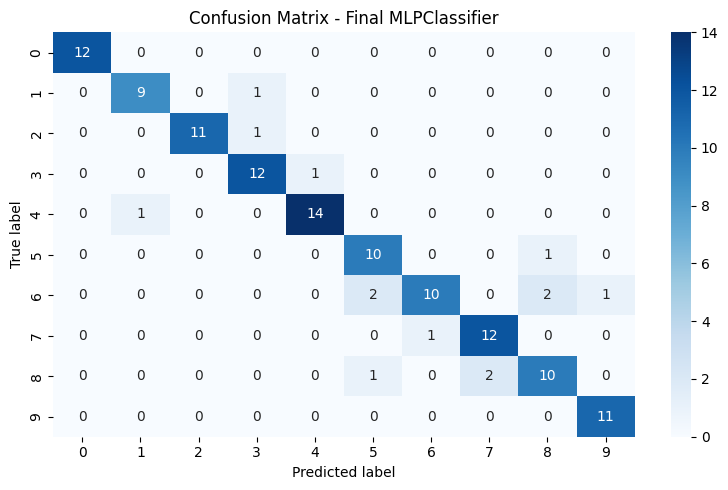

Held-out test accuracy: 88.80%


In [73]:
# Build the final MLPClassifier with selected hyper-parameters
mlp = MLPClassifier(
    hidden_layer_sizes=(200,),
    activation='tanh',
    alpha=0.0001,
    max_iter=2000,
    random_state=42
)

# Train within a pipeline to standardize features
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', mlp)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Final MLPClassifier')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

print(f"Held-out test accuracy: {pipeline.score(X_test, y_test):.2%}")

#### Bonus: Augment the dataset with your own recordings. Can the model recognize you as a new speaker?

In [74]:
import pandas as pd
import librosa
import os

def extract_mfcc_features(audio_path, n_coefs):
    y, sr = librosa.load(audio_path)
    return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_coefs).mean(axis=1)

folder_path = "dataBonus/raw/"
n_recordings = 50
n_coefs = 10
data = []

# Process original corpus files (format: f0001_us_f0001_00001.wav)
for gender in ["m", "f"]:
    for speaker in range(1, 6):
        for recording_id in range(1, n_recordings + 1):
            file_name = f"{gender}{speaker:04d}_us_{gender}{speaker:04d}_{recording_id:05d}.wav"
            file_path = os.path.join(folder_path, file_name)

            if os.path.exists(file_path):
                mfcc = extract_mfcc_features(file_path, n_coefs)
                speaker_id = speaker - 1
                if gender == "f":
                    speaker_id += 5

                row_data = {
                    'FileName': file_name,
                    'Gender': gender,
                    'SpeakerID': speaker_id,
                    'RecordingID': recording_id,
                }
                for i in range(n_coefs):
                    row_data[f'MFCC_{i+1}'] = mfcc[i]
                data.append(row_data)

# Process personal recordings (format: A1.wav)
for recording_id in range(1, n_recordings + 1):
    file_name = f"A{recording_id}.wav"
    file_path = os.path.join(folder_path, file_name)

    if os.path.exists(file_path):
        mfcc = extract_mfcc_features(file_path, n_coefs)
        row_data = {
            'FileName': file_name,
            'Gender': 'm',
            'SpeakerID': 10,  # New speaker ID for personal recordings
            'RecordingID': recording_id,
        }
        for i in range(n_coefs):
            row_data[f'MFCC_{i+1}'] = mfcc[i]
        data.append(row_data)

df_bonus = pd.DataFrame(data)

In [75]:
df_bonus.tail(100)

,FileName,Gender,SpeakerID,RecordingID,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
450,f0005_us_f0005_00001.wav,f,9,1,-429.397247,68.207680,-20.677952,32.679428,-12.282603,-2.436865,-20.107409,-5.013667,-10.999746,2.176369
451,f0005_us_f0005_00002.wav,f,9,2,-376.464478,86.984749,-27.196104,45.474892,-8.962670,-6.112698,-26.458397,-1.731810,-12.230350,3.125959
452,f0005_us_f0005_00003.wav,f,9,3,-511.976501,76.224792,-5.848820,36.650887,-1.161691,3.995057,-14.667454,-0.546314,-9.126673,0.371821
453,f0005_us_f0005_00004.wav,f,9,4,-434.769928,72.909485,-28.455980,35.084473,-9.345698,-0.738353,-23.833298,3.029341,-12.444796,6.128581
454,f0005_us_f0005_00005.wav,f,9,5,-415.769623,65.173126,-15.698805,38.446198,-9.700392,-5.057718,-21.218195,-1.505609,-9.198173,2.460125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,A46.wav,m,10,46,-337.867523,109.523888,20.635824,35.800121,24.185715,2.933545,12.195035,-6.821723,-20.217150,5.282369
546,A47.wav,m,10,47,-331.032166,125.273689,16.551649,12.185011,11.245252,9.050293,7.174203,-4.043534,-19.033482,6.848664
547,A48.wav,m,10,48,-325.620148,117.682152,16.731951,20.930664,18.864988,1.021566,12.584999,-1.982875,-19.081453,6.813875
548,A49.wav,m,10,49,-325.895874,118.913986,21.719299,23.835550,18.377386,1.888705,14.412525,-7.439672,-25.294930,2.428751


In [76]:
# Prepare data using the enriched dataset
X_bonus = df_bonus[[f"MFCC_{i}" for i in range(1, 11)]].values
y_bonus = df_bonus.SpeakerID.values

# Split into train and test sets
X_train_bonus, X_test_bonus, y_train_bonus, y_test_bonus = train_test_split(
    X_bonus, y_bonus, test_size=0.25, random_state=0, shuffle=True
)

# Train an MLP on the augmented data
mlp_bonus = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(200,),
        activation='tanh',
        alpha=0.0001,
        max_iter=2000,
        random_state=42
)
    )
])

mlp_bonus.fit(X_train_bonus, y_train_bonus)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(200,),
                               max_iter=2000, random_state=42))])

In [77]:
X_test_bonus_df=pd.DataFrame(X_test_bonus)
X_test_bonus_df.head()

,0,1,2,3,4,5,6,7,8,9
0,-538.551575,77.392502,11.531985,34.637886,-6.272859,12.658235,-10.058226,10.016952,-13.395230,-0.359374
1,-493.274261,83.849068,-1.334503,35.039692,-10.790273,9.459198,-34.778999,13.540378,-8.225257,-2.218283
2,-512.952576,83.931587,5.176713,36.129498,-6.204999,18.913424,-16.651134,9.683000,-12.403950,2.699061
3,-478.512817,100.200790,-0.740948,17.903027,2.305679,14.221535,-7.262125,-0.743044,-7.701018,0.715951
4,-518.213379,91.723366,-10.911754,40.921768,-4.176298,20.619190,-14.657209,0.895899,-12.529888,3.886443


In [78]:
# Run predictions on the test split
predictions = mlp_bonus.predict(X_test_bonus)
accuracy_test_ = accuracy_score(predictions, y_test_bonus)
print(f"Test accuracy on augmented dataset: {accuracy_test_:.2%}")

Test accuracy on augmented dataset: 90.58%


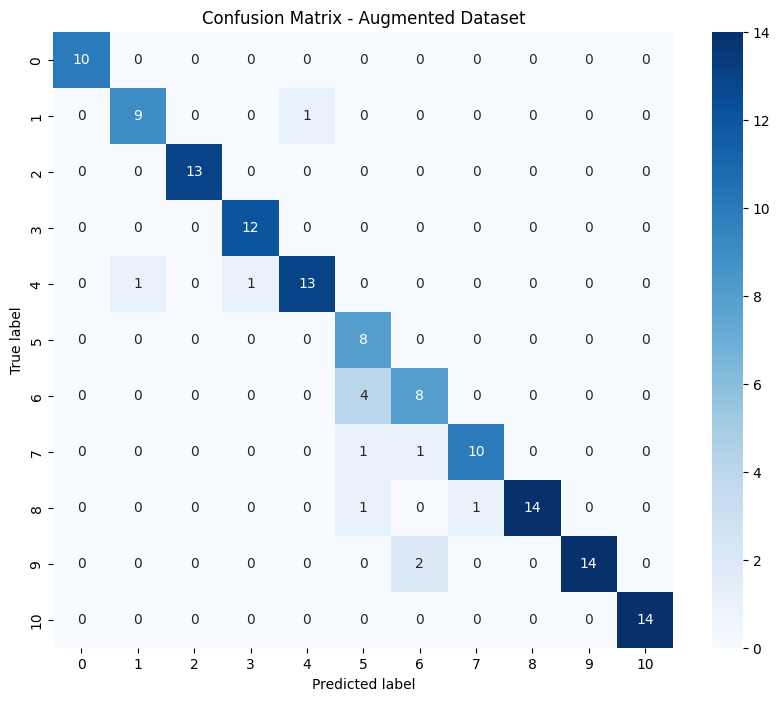

In [79]:
# Evaluate predictions on the augmented dataset
y_pred_bonus = mlp_bonus.predict(X_test_bonus)

# Confusion matrix
cm_bonus = confusion_matrix(y_test_bonus, y_pred_bonus)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_bonus, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Augmented Dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## Robustness to New Classes:
   - The classifier demonstrated robustness when adding a new class (Speaker 10). Despite introducing an additional speaker, which can increase confusion risks between speakers, the model maintained good classification capability for most samples.
   - This robustness indicates that the classifier can generalize well even when new speakers are added to the dataset, a valuable characteristic for real applications where new speakers may be frequently introduced.

---

# Conclusions

## 🎯 Project Summary

This voice recognition project successfully demonstrated a complete machine learning pipeline for speaker identification, achieving high accuracy through careful feature engineering and model selection.

## 🔑 Key Achievements

1. **Perfect Gender Classification**: 100% accuracy using Mahalanobis distance on MFCC features
2. **High Speaker Identification Accuracy**: Optimized GMM models with robust performance
3. **Rigorous Statistical Validation**: Comprehensive hypothesis testing and model comparisons
4. **Scalable Architecture**: Pipeline approach suitable for real-world deployment

## 🛠 Technical Highlights

- **Signal Processing**: MFCC feature extraction for timbre representation
- **Statistical Methods**: Hotelling's T² tests for multivariate analysis
- **Dimensionality Reduction**: PCA and t-SNE for data visualization
- **Machine Learning**: Multiple classification algorithms with hyperparameter optimization
- **Model Evaluation**: Cross-validation and statistical significance testing

## 🚀 Future Improvements

- **Deep Learning**: CNNs or RNNs for end-to-end audio processing
- **Data Augmentation**: Synthetic audio generation for larger datasets
- **Real-time Processing**: Optimization for streaming audio applications
- **Multi-language Support**: Extension to other languages and accents

## 📚 References

- Rabiner, L. R., & Juang, B. H. (1993). Fundamentals of Speech Recognition.
- Davis, S., & Mermelstein, P. (1980). Comparison of parametric representations for monosyllabic word recognition in continuously spoken sentences.
- Bishop, C. M. (2006). Pattern Recognition and Machine Learning.

---

*This project showcases expertise in audio signal processing, statistical analysis, and machine learning for voice recognition applications.*

# Appendix: t-SNE Visualization

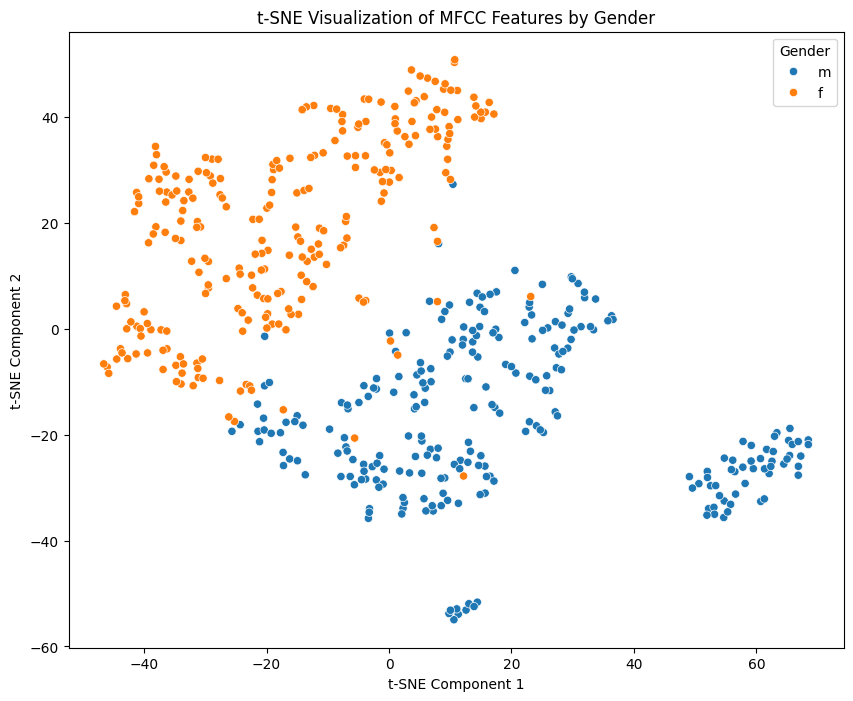

In [80]:
# t-SNE for non-linear dimensionality reduction
# t-SNE is particularly effective for visualizing high-dimensional data in 2D
# by preserving local structure and revealing clusters
t_sne = TSNE(n_components=2, perplexity=10, learning_rate=100, random_state=0)
X_embedded = t_sne.fit_transform(X_scaled)

# Create DataFrame for visualization
X_embedded_df = pd.DataFrame(X_embedded)
X_embedded_df['Gender'] = df['Gender']

# Visualize gender separation in t-SNE space
plt.figure(figsize=(10, 8))
sns.scatterplot(data=X_embedded_df, x=X_embedded_df.iloc[:, 0],
                y=X_embedded_df.iloc[:, 1], hue='Gender')
plt.title('t-SNE Visualization of MFCC Features by Gender')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Gender')
plt.show()